In [1]:
import numpy as np
from numpy.linalg import norm
from typing import Union
from EDAspy.optimization import UMDAc
from EDAspy.optimization import EGNA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mpcol
from pandas.plotting import parallel_coordinates
import pickle
import os

## Oscilador armónico cuántico
Otro problema típico es el oscilador armónico. (Clásicamente procedente de una fuerza tipo $F = -k x$). En este caso el potencial $V(x) = \frac{1}{2}\mu\omega^2 x^2$ donde x es el desplazamiento desde la posición de equilibrio (pozo del potencial) de manera que el hamiltoniano se escribe como:

$$\hat{H} | \Psi> = E | \Psi> \quad \longrightarrow \quad
 \left(-\frac{\hbar²}{2\mu}\frac{d²}{dx²} + V(x)\right)\Psi(x) \longrightarrow \quad \left(-\frac{\hbar²}{2\mu}\frac{d²}{dx²} + \frac{1}{2}\mu\omega^2 x^2 \right)\Psi(x)= E \Psi(x)$$

Las soluciones analíticas dependen de los polinomios de Hermite con sus respectivas energías:

$$ \Psi _n = N_n e^{-\beta^2 x^2 / 2} H_n (\beta x ) \quad ; \quad E_n = (n + \frac{1}{2}) \hbar \omega \quad con \,\,\, n = 0, 1, 2, ...$$

siendo $N_n$ la constante de normalización de cada solución, $\beta = \sqrt{m \omega / \hbar}$ y $H_n(y)$ el polinomio de Hermite de grado n que tienen la forma:
$$H_0(y) = 1  \quad H_1(y) = 2y  \quad H_2(y) = 4y^2 - 2 \quad H_3(y) = 8y^3 - 12 y$$

Usaremos como función de optimización: $$ Z = \left[\frac{<\Psi|\hat{H}|\Psi>}{<\Psi|\Psi>} - E_l\right]² $$

Las soluciones $\Psi(x)$ ahora ocuparán todo el espacio $(-\infty, \infty)$. Para tener una idea del grid que vamos a utilizar representamos previamente la función con los valores que usaremos $m=\omega=1$

In [2]:
print("Las energías válidas con w=m=\hbar=1 son")
for i in range(4):
    print(f"E_{i} = {i+0.5}")

Las energías válidas con w=m=\hbar=1 son
E_0 = 0.5
E_1 = 1.5
E_2 = 2.5
E_3 = 3.5


Text(0, 0.5, 'V(x)')

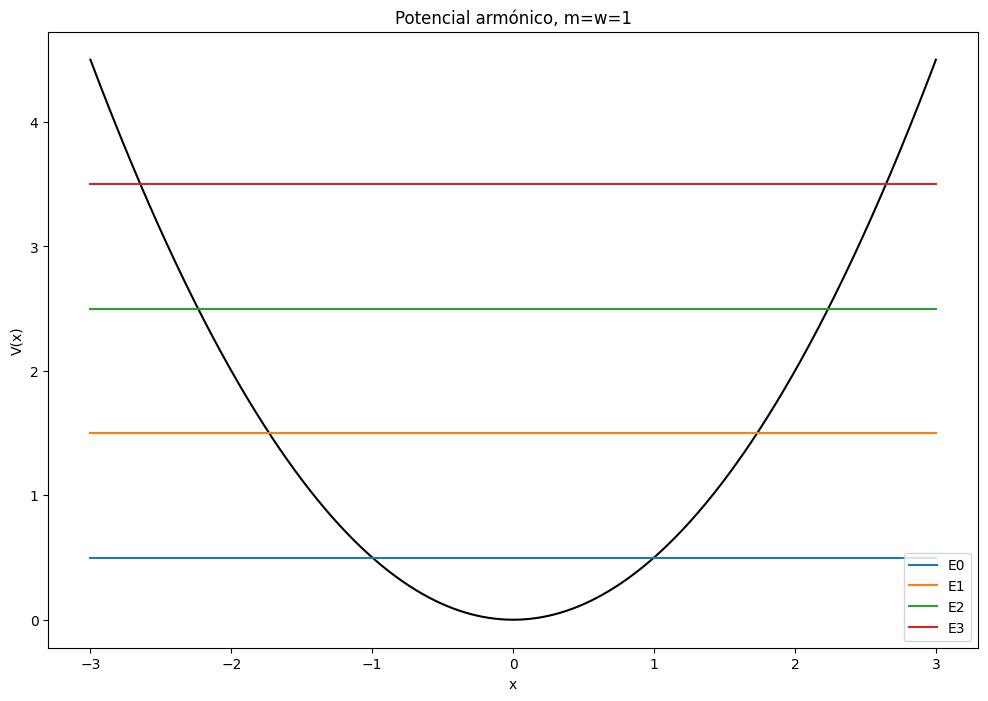

In [3]:
plt.figure(figsize=(12, 8))
plt.plot(np.linspace(-3, 3, 1000), 0.5 * np.linspace(-3, 3, 1000) ** 2, "k-")
plt.plot(np.linspace(-3, 3, 1000), 0.5 * np.linspace(1, 1, 1000), label="E0")
plt.plot(np.linspace(-3, 3, 1000), 1.5 * np.linspace(1, 1, 1000), label="E1")
plt.plot(np.linspace(-3, 3, 1000), 2.5 * np.linspace(1, 1, 1000), label="E2")
plt.plot(np.linspace(-3, 3, 1000), 3.5 * np.linspace(1, 1, 1000), label="E3")
plt.title("Potencial armónico, m=w=1")
plt.legend(loc="lower right")
plt.xlabel("x")
plt.ylabel("V(x)")

En vista del plot y las energías válidas, podemos elegir un grid que vaya de $x \in [-4, 4]$

In [4]:
# Definición de la función de optimización basada en referencia: Direct solution of Schrödinger equation by genetic algorithm:
# test cases
###############################
def oneDHOExpE(y: Union[np.array, list]) -> float:
    "Estamos discretizando el espacio entre los puntos x=-4 a x=4 con el número de puntos que se pasen como input al EDA"
    # Energy_lower bound
    E = 0
    # grid size x=[-4, 4]
    n = len(y)
    x = np.linspace(-4, 4, n)
    dx = 8 / (n - 1)
    # integral sums
    ExpE = 0
    j = 0
    if (y[0] < -0.1 or y[0] > 0.1) or (y[n - 1] < -0.1 or y[n - 1] > 0.1):
        F = np.infty
        return F
    else:
        for i in range(n):
            if i == 0:
                ExpE = ExpE + y[i] * dx * (
                    -0.5 * (y[i] + y[i + 2] - 2 * y[i + 1]) / dx**2
                    + 0.5 * x[i] ** 2 * y[i]
                )
                j = j + y[i] ** 2 * dx

            elif i == n - 1:
                ExpE = ExpE + y[i] * dx * (
                    -0.5 * (y[i] + y[i - 2] - 2 * y[i - 1]) / dx**2
                    + 0.5 * x[i] ** 2 * y[i]
                )
                j = j + y[i] ** 2 * dx

            else:
                ExpE = ExpE + y[i] * dx * (
                    -0.5 * (y[i - 1] + y[i + 1] - 2 * y[i]) / dx**2
                    + 0.5 * x[i] ** 2 * y[i]
                )
                j = j + y[i] ** 2 * dx

    Z = (ExpE / j - E) ** 2
    # F = -1*np.exp(-cons*Z) #con signo menos global para minimizar
    return Z

In [5]:
n_variables = 41
print("El tamaño de grid es", 8 / (n_variables - 1))

El tamaño de grid es 0.2


In [6]:
Psi0 = np.exp(-np.linspace(-4, 4, n_variables) ** 2 / 2)
integral = 0
for i in range(len(Psi0)):
    integral = integral + (Psi0[i] ** 2) * (8 / (len(Psi0) - 1))

B = (1 / integral) ** 0.5
Psi0 = B * Psi0

In [7]:
print(
    "La solución analítica tiene un fitness según la función de optimización",
    oneDHOExpE(Psi0),
    "y debería ser",
    0.5**2,
)

La solución analítica tiene un fitness según la función de optimización 0.24875552459837724 y debería ser 0.25


In [8]:
# whites es una lista con los arcos obligatorios que aprender
#'Continuidad de la función'
whites1 = [(str(i), str(i + 1)) for i in range(n_variables - 1)]

# simetría de la función
whites2 = [(str(i), str(n_variables - i - 1)) for i in range((n_variables // 2))]

whites = whites1 + whites2
# whites

# EDAs

In [9]:
execute_edas = False

In [10]:
results_dict = {}
objects = ["eda_resultExpE", "eda_resultExpE1", "eda_resultExpE2", "eda_resultExpE3"]

In [11]:
ruta = "Results/QHarmOsc"

In [12]:
## Si no se ejecutan EDAs usamos soluciones de un run anterior previamente guardado

if not execute_edas:
    for key in objects:
        with open(f"{ruta}/{key}.pkl", "rb") as file:
            results_dict[key] = pickle.load(file)

In [13]:
if execute_edas:
    qumda = EGNA(
        size_gen=1500,
        max_iter=120,
        dead_iter=120,
        n_variables=n_variables,
        lower_bound=0,
        upper_bound=1,
        alpha=0.6,
        parallelize=True,
        white_list=whites,
    )
    results_dict["eda_resultExpE"] = qumda.minimize(oneDHOExpE, True)

IT:  0 	Best cost:  999999999999


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  1 	Best cost:  26.154630030552145


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  2 	Best cost:  26.154630030552145


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  3 	Best cost:  26.154630030552145


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  4 	Best cost:  26.154630030552145


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  5 	Best cost:  26.154630030552145


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  6 	Best cost:  26.154630030552145


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  7 	Best cost:  26.154630030552145


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  8 	Best cost:  25.897532339415058


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  9 	Best cost:  25.897532339415058


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  10 	Best cost:  25.897532339415058


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  11 	Best cost:  25.897532339415058


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  12 	Best cost:  25.897532339415058


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  13 	Best cost:  25.897532339415058


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  14 	Best cost:  25.897532339415058


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  15 	Best cost:  17.451780958083912


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  16 	Best cost:  17.41530838919546


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  17 	Best cost:  11.979234820128363


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  18 	Best cost:  8.14658222420129


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  19 	Best cost:  7.223404338917802


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  20 	Best cost:  6.838790420468188


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  21 	Best cost:  5.320878915917649


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  22 	Best cost:  3.9632698414802525


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  23 	Best cost:  3.6132253142873814


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  24 	Best cost:  3.257341738870257


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  25 	Best cost:  2.678362570404531


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  26 	Best cost:  1.7110525420765206


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  27 	Best cost:  1.7110525420765206


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  28 	Best cost:  1.5650841199247103


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  29 	Best cost:  1.5650841199247103


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  30 	Best cost:  1.3205966873840818


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  31 	Best cost:  1.1948005726643482


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  32 	Best cost:  1.0809239759787972


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  33 	Best cost:  1.0345045916339248


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  34 	Best cost:  0.8606246380548418


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  35 	Best cost:  0.8265138747070817


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  36 	Best cost:  0.6961831153932717


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  37 	Best cost:  0.6488881825443037


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  38 	Best cost:  0.6459257993413658


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  39 	Best cost:  0.61202642148156


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  40 	Best cost:  0.5767528239862296


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  41 	Best cost:  0.5502995822729847


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  42 	Best cost:  0.5219658271395514


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  43 	Best cost:  0.4963242260872174


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  44 	Best cost:  0.49448448788219185


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  45 	Best cost:  0.4659025083187334


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  46 	Best cost:  0.44325728424040145


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  47 	Best cost:  0.44325728424040145


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  48 	Best cost:  0.42827610846825115


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  49 	Best cost:  0.42689417927953965


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  50 	Best cost:  0.4182496483833625


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  51 	Best cost:  0.41157472447472554


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  52 	Best cost:  0.4074516022141662


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  53 	Best cost:  0.40445164055745314


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  54 	Best cost:  0.39831198920762895


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  55 	Best cost:  0.39344076124642857


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  56 	Best cost:  0.39028661426945255


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  57 	Best cost:  0.3890627317416833


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  58 	Best cost:  0.38669972070065783


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  59 	Best cost:  0.38435386008840283


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  60 	Best cost:  0.3807596264305133


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  61 	Best cost:  0.3807596264305133


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  62 	Best cost:  0.37981356878752237


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  63 	Best cost:  0.37825362659091866


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  64 	Best cost:  0.37658618072916744


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  65 	Best cost:  0.3754948430181221


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  66 	Best cost:  0.37431460151247464


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  67 	Best cost:  0.3731001960089944


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  68 	Best cost:  0.3731001960089944


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  69 	Best cost:  0.37217483058102657


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  70 	Best cost:  0.37153473531567505


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  71 	Best cost:  0.37120640445244957


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  72 	Best cost:  0.3709725983863622


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  73 	Best cost:  0.37026547670300897


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  74 	Best cost:  0.3703028588033884


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  75 	Best cost:  0.36992179119422086


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  76 	Best cost:  0.3694880308945866


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  77 	Best cost:  0.36912751025664575


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  78 	Best cost:  0.36914698288960307


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  79 	Best cost:  0.36879838556218497


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  80 	Best cost:  0.3677865973266084


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  81 	Best cost:  0.36792673888605526


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  82 	Best cost:  0.36647896169055605


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  83 	Best cost:  0.36462891600916136


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  84 	Best cost:  0.3628687360264563


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  85 	Best cost:  0.3620162221449334


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  86 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  87 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  88 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  89 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  90 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  91 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  92 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  93 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  94 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  95 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  96 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  97 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  98 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  99 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  100 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  101 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  102 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  103 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  104 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  105 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  106 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  107 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  108 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  109 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  110 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  111 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  112 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  113 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  114 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  115 	Best cost:  0.3587433938869888


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  116 	Best cost:  0.35908881480446025


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  117 	Best cost:  0.3590675687310309


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  118 	Best cost:  0.35902175034341327


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  119 	Best cost:  0.35895277970691286
	NFEVALS = 180000 F = 0.35895277970691286
	X = [[-0.07047319  0.06257108  0.06016362  0.08434154  0.11230485  0.14453067
   0.1767513   0.18741852  0.21458083  0.27795348  0.33376793  0.40078539
   0.50038661  0.60281331  0.72162584  0.85018452  0.9513702   1.02660073
   1.06840217  1.11374941  1.12595597  1.09256101  1.05418406  1.00409449
   0.92253328  0.81695566  0.70553275  0.60106244  0.49334494  0.40706792
   0.33165692  0.24898825  0.19070939  0.15282113  0.13155733  0.13912336
   0.1355878   0.15467915  0.08707717  0.01492708  0.09935099]]


In [14]:
objects = {"eda_resultExpE": results_dict["eda_resultExpE"]}


# Cálculo de las constantes para normalización mejor solución
for element in objects.keys():
    integral = 0
    for i in range(len(objects[element].sel_inds_hist[-1, 0, :-1])):
        integral = integral + (objects[element].sel_inds_hist[-1, 0, :-1][i] ** 2) * (
            8 / (n_variables - 1)
        )

    B = (1 / integral) ** 0.5
    objects[element].sel_inds_hist[-1, 0, :-1] = (
        B * objects[element].sel_inds_hist[-1, 0, :-1]
    )

In [15]:
print(
    "La energía esperada de la solución encontrada es:",
    results_dict["eda_resultExpE"].sel_inds_hist[-1, 0, -1] ** 0.5,
    "\nEl valor teórico es 0.5",
)

La energía esperada de la solución encontrada es: 0.598951912833567 
El valor teórico es 0.5


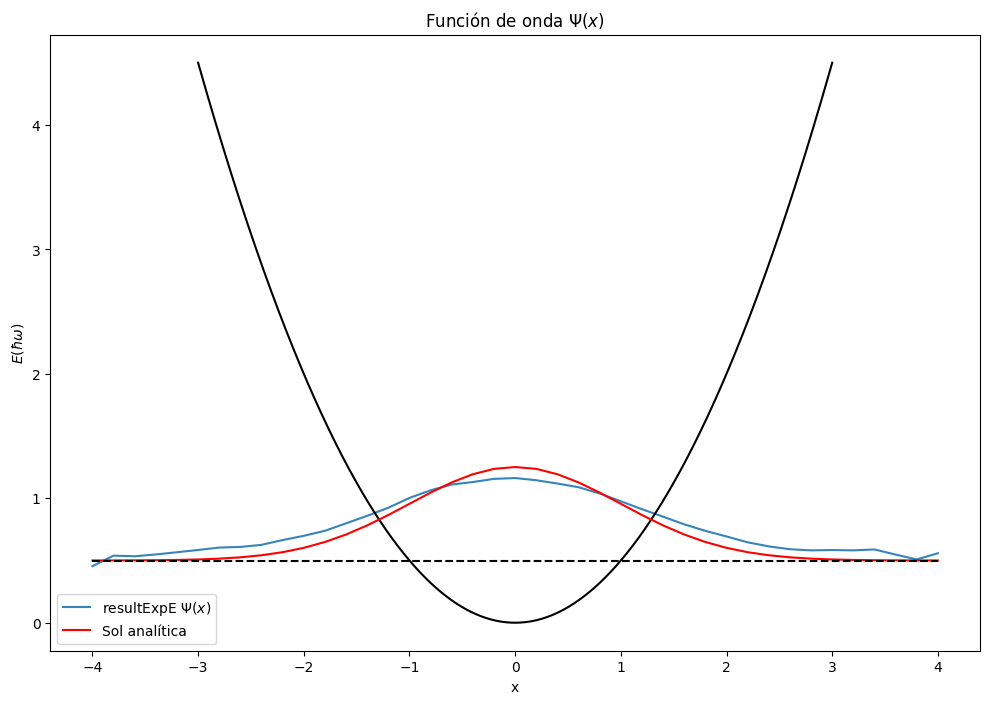

In [16]:
plt.figure(figsize=(12, 8))
for element in objects.keys():
    plt.plot(
        np.linspace(-4, 4, n_variables),
        0.5 + objects[element].sel_inds_hist[-1, 0, :-1],
        "-",
        label=f'{element.split("da_")[1]} $\Psi(x)$',
        alpha=0.9,
    )

plt.plot(np.linspace(-3, 3, 1000), 0.5 * np.linspace(-3, 3, 1000) ** 2, "k-")
plt.plot(np.linspace(-4, 4, n_variables), 0.5 + Psi0, "r-", label="Sol analítica")
plt.plot(np.linspace(-4, 4, 2), np.linspace(0.5, 0.5, 2), "k--")
plt.gca().set_title("Función de onda $\Psi(x)$")
plt.xlabel("x")
plt.gca().set_ylabel(r"$E (\hbar \omega)$")
plt.legend()

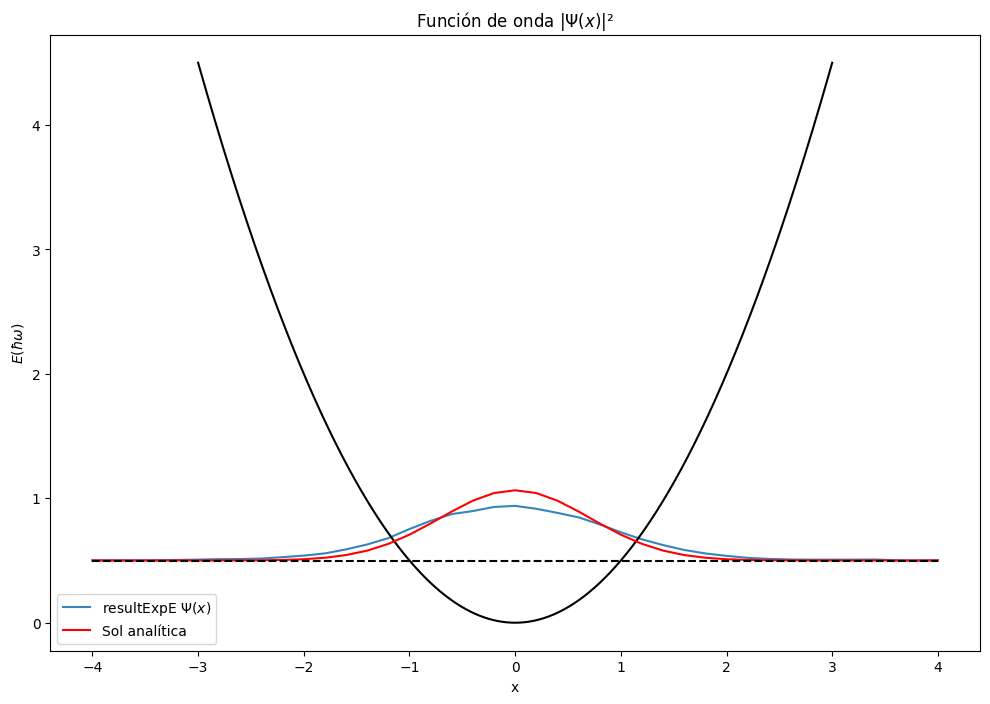

In [17]:
plt.figure(figsize=(12, 8))
for element in objects.keys():
    plt.plot(
        np.linspace(-4, 4, n_variables),
        0.5 + objects[element].sel_inds_hist[-1, 0, :-1] ** 2,
        "-",
        label=f'{element.split("da_")[1]} $\Psi(x)$',
        alpha=0.9,
    )

plt.plot(np.linspace(-3, 3, 1000), 0.5 * np.linspace(-3, 3, 1000) ** 2, "k-")
plt.plot(np.linspace(-4, 4, n_variables), 0.5 + Psi0**2, "r-", label="Sol analítica")
plt.plot(np.linspace(-4, 4, 2), np.linspace(0.5, 0.5, 2), "k--")
plt.gca().set_title("Función de onda $|\Psi(x)|²$")
plt.xlabel("x")
plt.gca().set_ylabel(r"$E (\hbar \omega)$")
plt.legend()

## Estados excitados n=1
Usaremos el mismo approach que con la partícula en la caja.
$$ Z = \left[\frac{<\Phi|\hat{H}|\Phi>}{<\Phi|\Phi>} - E_l\right]² + \beta |<\Psi|\Phi>|²$$
siendo $\Psi(x)$ el estado fundamental ya encontrado con n=0 y $E_l$ el valor esperado de su energía

In [18]:
def oneDHOExpE1(y: Union[np.array, list]) -> float:
    "Estamos discretizando el espacio entre los puntos x=-4 a x=4 con el número de puntos que se pasen como input al EDA"
    # Energy_lower bound
    E = (
        results_dict["eda_resultExpE"].sel_inds_hist[-1, 0, -1] ** 0.5
    )  # valor esperado energía n=0
    # grid size x=[-4, 4]
    n = len(y)
    x = np.linspace(-4, 4, n)
    dx = 8 / (n - 1)
    # integral sums
    ExpE = 0
    j = 0
    orto = 0
    if (y[0] < -0.1 or y[0] > 0.1) or (y[n - 1] < -0.1 or y[n - 1] > 0.1):
        F = np.infty
        return F
    else:
        for i in range(n):
            if i == 0:
                ExpE = ExpE + y[i] * dx * (
                    -0.5 * (y[i] + y[i + 2] - 2 * y[i + 1]) / dx**2
                    + 0.5 * x[i] ** 2 * y[i]
                )
                j = j + y[i] ** 2 * dx
                orto = (
                    orto
                    + y[i]
                    * results_dict["eda_resultExpE"].sel_inds_hist[-1, 0, :-1][i]
                    * dx
                )

            elif i == n - 1:
                ExpE = ExpE + y[i] * dx * (
                    -0.5 * (y[i] + y[i - 2] - 2 * y[i - 1]) / dx**2
                    + 0.5 * x[i] ** 2 * y[i]
                )
                j = j + y[i] ** 2 * dx
                orto = (
                    orto
                    + y[i]
                    * results_dict["eda_resultExpE"].sel_inds_hist[-1, 0, :-1][i]
                    * dx
                )

            else:
                ExpE = ExpE + y[i] * dx * (
                    -0.5 * (y[i - 1] + y[i + 1] - 2 * y[i]) / dx**2
                    + 0.5 * x[i] ** 2 * y[i]
                )
                j = j + y[i] ** 2 * dx
                orto = (
                    orto
                    + y[i]
                    * results_dict["eda_resultExpE"].sel_inds_hist[-1, 0, :-1][i]
                    * dx
                )

    Z = (ExpE / j - E) ** 2 + 10 * orto**2
    # F = -1*np.exp(-cons*Z) #con signo menos global para minimizar
    return Z

In [19]:
if execute_edas:
    qumda = EGNA(
        size_gen=1500,
        max_iter=80,
        dead_iter=80,
        n_variables=n_variables,
        lower_bound=-1,
        upper_bound=1,
        alpha=0.6,
        parallelize=True,
        white_list=whites,
    )
    results_dict["eda_resultExpE1"] = qumda.minimize(oneDHOExpE1, True)

IT:  0 	Best cost:  999999999999


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  1 	Best cost:  234.04522910544787


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  2 	Best cost:  234.04522910544787


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  3 	Best cost:  234.04522910544787


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  4 	Best cost:  234.04522910544787


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  5 	Best cost:  234.04522910544787


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  6 	Best cost:  234.04522910544787


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  7 	Best cost:  234.04522910544787


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  8 	Best cost:  234.04522910544787


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  9 	Best cost:  234.04522910544787


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  10 	Best cost:  214.88489311350122


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  11 	Best cost:  212.84083020750364


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  12 	Best cost:  212.84083020750364


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  13 	Best cost:  80.6406102604399


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  14 	Best cost:  80.6406102604399


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  15 	Best cost:  76.41292064490345


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  16 	Best cost:  48.169793518752904


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  17 	Best cost:  43.84663137066683


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  18 	Best cost:  23.12424031824588


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  19 	Best cost:  11.094977786748228


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT: 

/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


 20 	Best cost:  11.094977786748228
IT:  21 	Best cost:  4.644851658721652


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  22 	Best cost:  2.8253575792095127


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  23 	Best cost:  2.8253575792095127


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  24 	Best cost:  2.3990183299828787


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  25 	Best cost:  2.151278718832552


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  26 	Best cost:  2.151278718832552


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  27 	Best cost:  2.0522643512434677


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  28 	Best cost:  1.7162031509517566


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  29 	Best cost:  1.7162031509517566


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  30 	Best cost:  1.7050709470778094


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  31 	Best cost:  1.6123825393786138


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  32 	Best cost:  1.424017401509109


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  33 	Best cost:  1.3670663063688173


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  34 	Best cost:  1.3305782585736605


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  35 	Best cost:  1.3037215760085432


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  36 	Best cost:  1.2636502577472235


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  37 	Best cost:  1.200854999812351


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  38 	Best cost:  1.1879285318066455


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  39 	Best cost:  1.120895268284374


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  40 	Best cost:  1.091603414015944


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  41 	Best cost:  1.091603414015944


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  42 	Best cost:  1.0717594399984152


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  43 	Best cost:  1.0371966081985797


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  44 	Best cost:  1.0371966081985797


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  45 	Best cost:  1.0196825983993452


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  46 	Best cost:  1.0038643966755956


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  47 	Best cost:  0.9865548552133576


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  48 	Best cost:  0.9818213943823655


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  49 	Best cost:  0.9765675072859087


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  50 	Best cost:  0.9553773986334942


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  51 	Best cost:  0.9538801448885974


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  52 	Best cost:  0.9418597987324226


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  53 	Best cost:  0.9376608612939917


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  54 	Best cost:  0.9359273377944155


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  55 	Best cost:  0.9322062726184933


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  56 	Best cost:  0.9283569493197323


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  57 	Best cost:  0.9231019610366138


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  58 	Best cost:  0.9209935395124628


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  59 	Best cost:  0.9119581156924087


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  60 	Best cost:  0.9119581156924087


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  61 	Best cost:  0.9125205754338204


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  62 	Best cost:  0.9112936635092997


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  63 	Best cost:  0.9089231781579953


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  64 	Best cost:  0.9071485958435865


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  65 	Best cost:  0.9049751574820089


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  66 	Best cost:  0.904866440754125


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  67 	Best cost:  0.9040818477225343


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  68 	Best cost:  0.9029345645549816


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  69 	Best cost:  0.9011450246745607


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  70 	Best cost:  0.9007347318774033


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  71 	Best cost:  0.9001178833330098


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  72 	Best cost:  0.8998515855587451


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  73 	Best cost:  0.8988723957810661


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  74 	Best cost:  0.8984620314159614


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  75 	Best cost:  0.8977401794252405


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  76 	Best cost:  0.8973836376618907


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  77 	Best cost:  0.8969318392168285


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  78 	Best cost:  0.896806976668722


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  79 	Best cost:  0.896558020296148
	NFEVALS = 120000 F = 0.896558020296148
	X = [[-0.09606444  0.01308517 -0.01507573  0.01992882  0.06146102  0.14531483
   0.26422083  0.45552456  0.68790122  0.98626238  1.32474489  1.77691216
   2.20185373  2.68897291  3.00573217  2.94704561  2.67942109  2.39504669
   2.04584419  1.38958821  0.46774991 -0.41250674 -1.49625239 -2.51723625
  -3.25893611 -3.62159021 -3.73951212 -3.29290667 -2.90162649 -2.2481951
  -1.68644823 -1.24985653 -0.85449779 -0.53998387 -0.33579088 -0.19587123
  -0.11044144 -0.04032547 -0.01862853  0.00493193 -0.0629643 ]]


In [20]:
objects = {"eda_resultExpE": results_dict["eda_resultExpE1"]}


# Cálculo de las constantes para normalización mejor solución
for element in objects.keys():
    integral = 0
    for i in range(len(objects[element].sel_inds_hist[-1, 0, :-1])):
        integral = integral + (objects[element].sel_inds_hist[-1, 0, :-1][i] ** 2) * (
            8 / (n_variables - 1)
        )

    B = (1 / integral) ** 0.5
    objects[element].sel_inds_hist[-1, 0, :-1] = (
        B * objects[element].sel_inds_hist[-1, 0, :-1]
    )

In [21]:
print(
    "La energía esperada de la solución encontrada es:",
    results_dict["eda_resultExpE1"].sel_inds_hist[-1, 0, -1] ** 0.5
    + results_dict["eda_resultExpE"].sel_inds_hist[-1, 0, -1] ** 0.5,
    "\nEl valor teórico es 1.5",
)

La energía esperada de la solución encontrada es: 1.5459508445482348 
El valor teórico es 1.5


In [22]:
Psi1 = (
    np.exp(-np.linspace(-4, 4, n_variables) ** 2 / 2)
    * 2
    * np.linspace(-4, 4, n_variables)
)
integral = 0
for i in range(len(Psi1)):
    integral = integral + (Psi1[i] ** 2) * (8 / (len(Psi1) - 1))

B = (1 / integral) ** 0.5
Psi1 = B * Psi1

if results_dict["eda_resultExpE1"].sel_inds_hist[-1, 0, :-1][10] > 0:
    Psi1 = -Psi1

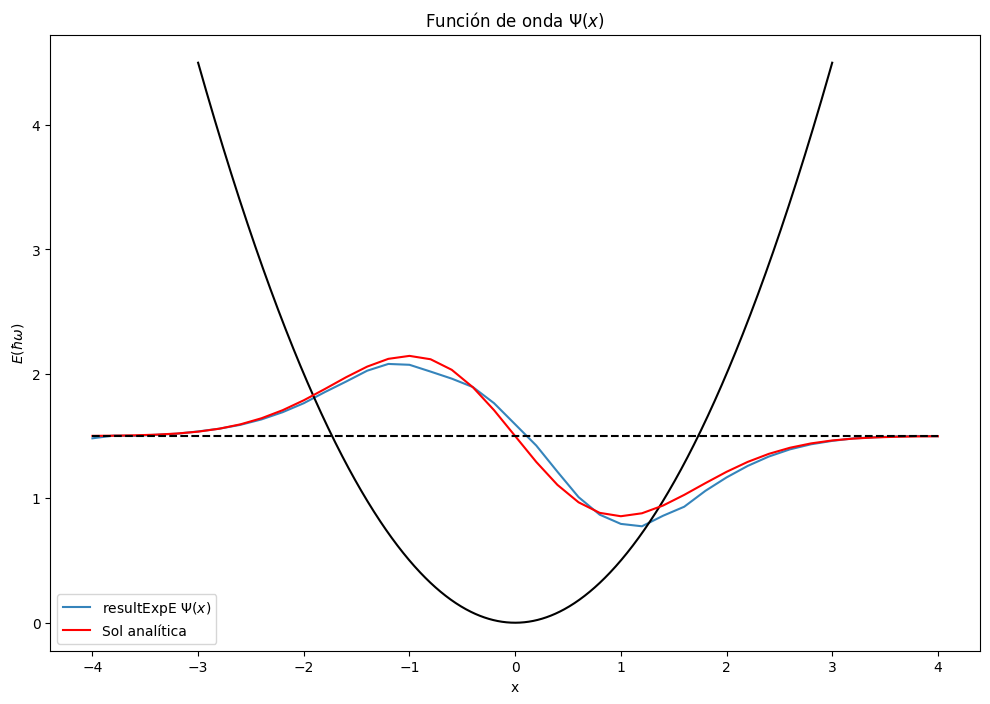

In [23]:
plt.figure(figsize=(12, 8))
for element in objects.keys():
    plt.plot(
        np.linspace(-4, 4, n_variables),
        1.5 + objects[element].sel_inds_hist[-1, 0, :-1],
        "-",
        label=f'{element.split("da_")[1]} $\Psi(x)$',
        alpha=0.9,
    )

plt.plot(np.linspace(-3, 3, 1000), 0.5 * np.linspace(-3, 3, 1000) ** 2, "k-")
plt.plot(np.linspace(-4, 4, n_variables), 1.5 + Psi1, "r-", label="Sol analítica")
plt.plot(np.linspace(-4, 4, 2), np.linspace(1.5, 1.5, 2), "k--")
plt.gca().set_title("Función de onda $\Psi(x)$")
plt.xlabel("x")
plt.gca().set_ylabel(r"$E(\hbar \omega)$")
plt.legend()

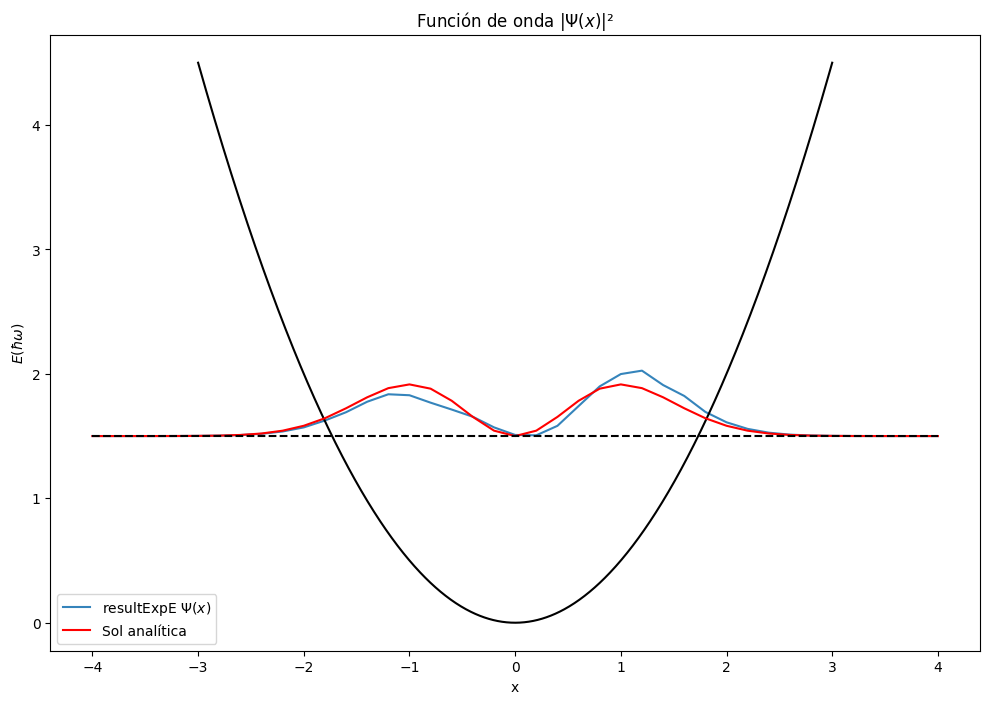

In [24]:
plt.figure(figsize=(12, 8))
for element in objects.keys():
    plt.plot(
        np.linspace(-4, 4, n_variables),
        1.5 + objects[element].sel_inds_hist[-1, 0, :-1] ** 2,
        "-",
        label=f'{element.split("da_")[1]} $\Psi(x)$',
        alpha=0.9,
    )

plt.plot(np.linspace(-3, 3, 1000), 0.5 * np.linspace(-3, 3, 1000) ** 2, "k-")
plt.plot(np.linspace(-4, 4, n_variables), 1.5 + Psi1**2, "r-", label="Sol analítica")
plt.plot(np.linspace(-4, 4, 2), np.linspace(1.5, 1.5, 2), "k--")
plt.gca().set_title("Función de onda $|\Psi(x)|²$")
plt.xlabel("x")
plt.gca().set_ylabel(r"$E(\hbar \omega)$")
plt.legend()

## Estado n=2

In [25]:
def oneDHOExpE2(y: Union[np.array, list]) -> float:
    "Estamos discretizando el espacio entre los puntos x=-4 a x=4 con el número de puntos que se pasen como input al EDA"
    # Energy_lower bound
    E = (
        results_dict["eda_resultExpE1"].sel_inds_hist[-1, 0, -1] ** 0.5
        + results_dict["eda_resultExpE"].sel_inds_hist[-1, 0, -1] ** 0.5
    )  # valor esperado energía n=1
    # grid size x=[-4, 4]
    n = len(y)
    x = np.linspace(-4, 4, n)
    dx = 8 / (n - 1)
    # integral sums
    ExpE = 0
    j = 0
    orto = 0
    orto1 = 0
    if (y[0] < -0.1 or y[0] > 0.1) or (y[n - 1] < -0.1 or y[n - 1] > 0.1):
        F = np.infty
        return F
    else:
        for i in range(n):
            if i == 0:
                ExpE = ExpE + y[i] * dx * (
                    -0.5 * (y[i] + y[i + 2] - 2 * y[i + 1]) / dx**2
                    + 0.5 * x[i] ** 2 * y[i]
                )
                j = j + y[i] ** 2 * dx
                orto = (
                    orto
                    + y[i]
                    * results_dict["eda_resultExpE"].sel_inds_hist[-1, 0, :-1][i]
                    * dx
                )
                orto1 = (
                    orto1
                    + y[i]
                    * results_dict["eda_resultExpE1"].sel_inds_hist[-1, 0, :-1][i]
                    * dx
                )

            elif i == n - 1:
                ExpE = ExpE + y[i] * dx * (
                    -0.5 * (y[i] + y[i - 2] - 2 * y[i - 1]) / dx**2
                    + 0.5 * x[i] ** 2 * y[i]
                )
                j = j + y[i] ** 2 * dx
                orto = (
                    orto
                    + y[i]
                    * results_dict["eda_resultExpE"].sel_inds_hist[-1, 0, :-1][i]
                    * dx
                )
                orto1 = (
                    orto1
                    + y[i]
                    * results_dict["eda_resultExpE1"].sel_inds_hist[-1, 0, :-1][i]
                    * dx
                )

            else:
                ExpE = ExpE + y[i] * dx * (
                    -0.5 * (y[i - 1] + y[i + 1] - 2 * y[i]) / dx**2
                    + 0.5 * x[i] ** 2 * y[i]
                )
                j = j + y[i] ** 2 * dx
                orto = (
                    orto
                    + y[i]
                    * results_dict["eda_resultExpE"].sel_inds_hist[-1, 0, :-1][i]
                    * dx
                )
                orto1 = (
                    orto1
                    + y[i]
                    * results_dict["eda_resultExpE1"].sel_inds_hist[-1, 0, :-1][i]
                    * dx
                )

    Z = (ExpE / j - E) ** 2 + 10 * orto**2 + 10 * orto1**2
    # F = -1*np.exp(-cons*Z) #con signo menos global para minimizar
    return Z

In [26]:
if execute_edas:
    qumda = EGNA(
        size_gen=1500,
        max_iter=80,
        dead_iter=80,
        n_variables=n_variables,
        lower_bound=-1,
        upper_bound=1,
        alpha=0.6,
        parallelize=True,
        white_list=whites,
    )
    results_dict["eda_resultExpE2"] = qumda.minimize(oneDHOExpE2, True)

IT:  0 	Best cost:  999999999999


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  1 	Best cost:  279.47439856894573


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  2 	Best cost:  279.47439856894573


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  3 	Best cost:  279.47439856894573


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  4 	Best cost:  279.47439856894573


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  5 	Best cost:  269.2840639120859


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  6 	Best cost:  269.2840639120859


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  7 	Best cost:  269.2840639120859


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  8 	Best cost:  264.27950228482496


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  9 	Best cost:  264.27950228482496


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  10 	Best cost:  212.51242515679743


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  11 	Best cost:  204.1187561132992


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  12 	Best cost:  204.1187561132992


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  13 	Best cost:  156.73212462896566


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  14 	Best cost:  106.38651111455624


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  15 	Best cost:  75.31414609469768


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  16 	Best cost:  44.20868098975971


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  17 	Best cost:  41.00348645571694


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  18 	Best cost:  21.543538684374198


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  19 	Best cost:  20.573263479126695


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  20 	Best cost:  17.996588487307847


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  21 	Best cost:  11.276288395591326


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  22 	Best cost:  7.0290986290991055


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  23 	Best cost:  5.325134458223654


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  24 	Best cost:  5.253925567728493


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  25 	Best cost:  4.302042762488553


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  26 	Best cost:  3.7482581346615285


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  27 	Best cost:  3.015355639963672


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  28 	Best cost:  2.25860914662808


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  29 	Best cost:  2.196006869637372


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  30 	Best cost:  2.0007677959023096


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  31 	Best cost:  1.7145604980002207


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  32 	Best cost:  1.6475883618458718


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  33 	Best cost:  1.4425559813929538


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  34 	Best cost:  1.3815932598447191


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  35 	Best cost:  1.1972870941582179


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  36 	Best cost:  1.152505804471093


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  37 	Best cost:  1.0767008760929997


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  38 	Best cost:  1.0035038811442836


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  39 	Best cost:  0.9644145588975993


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  40 	Best cost:  0.9278887705795466


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  41 	Best cost:  0.8807962760913343


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  42 	Best cost:  0.8614361460904493


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  43 	Best cost:  0.8532893817369355


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  44 	Best cost:  0.8238729363381968


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  45 	Best cost:  0.8222422058939628


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  46 	Best cost:  0.812802161935258


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  47 	Best cost:  0.7961381820474819


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  48 	Best cost:  0.7886732386136116


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  49 	Best cost:  0.785180785256498


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  50 	Best cost:  0.7765664478745458


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  51 	Best cost:  0.7720557350749103


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  52 	Best cost:  0.7634442375640157


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  53 	Best cost:  0.7632383831284844


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  54 	Best cost:  0.7609016768576885


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  55 	Best cost:  0.7565625081897492


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  56 	Best cost:  0.7540917184883302


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  57 	Best cost:  0.7535336529646547


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  58 	Best cost:  0.7516077442063844


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  59 	Best cost:  0.7489491652250891


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  60 	Best cost:  0.7467641689003557


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  61 	Best cost:  0.7467726487008713


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  62 	Best cost:  0.7455205936899049


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  63 	Best cost:  0.7453676658844149


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  64 	Best cost:  0.7428595501038339


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  65 	Best cost:  0.7421049294813191


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  66 	Best cost:  0.7425401118151587


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  67 	Best cost:  0.742089035450706


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  68 	Best cost:  0.7423599589597083


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  69 	Best cost:  0.7405881726554496


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  70 	Best cost:  0.7406738507445858


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  71 	Best cost:  0.740420158008781


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  72 	Best cost:  0.7402969667962082


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  73 	Best cost:  0.7394139847933431


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  74 	Best cost:  0.7398636418044585


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  75 	Best cost:  0.7395443407663939


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  76 	Best cost:  0.7391475494312377


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  77 	Best cost:  0.7389977724210064


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  78 	Best cost:  0.738980072303141


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  79 	Best cost:  0.7388579584232617
	NFEVALS = 120000 F = 0.7388579584232617
	X = [[-0.09268485 -0.02727582 -0.09757193 -0.14111607 -0.22579649 -0.35982629
  -0.54016383 -0.77272558 -1.06722767 -1.38944346 -1.70680616 -1.95009115
  -2.06400623 -1.97470382 -1.63042803 -1.04231474 -0.26898162  0.59090551
   1.3734658   1.94593998  2.20372191  2.10091822  1.67099353  1.00159576
   0.21152361 -0.54052266 -1.15104331 -1.53518502 -1.69799674 -1.66734184
  -1.4936932  -1.24125008 -0.96814375 -0.71606643 -0.50065403 -0.33055246
  -0.22084472 -0.13372602 -0.08359211 -0.00677748 -0.09381265]]


In [27]:
objects = {"eda_resultExpE": results_dict["eda_resultExpE2"]}


# Cálculo de las constantes para normalización mejor solución
for element in objects.keys():
    integral = 0
    for i in range(len(objects[element].sel_inds_hist[-1, 0, :-1])):
        integral = integral + (objects[element].sel_inds_hist[-1, 0, :-1][i] ** 2) * (
            8 / (n_variables - 1)
        )

    B = (1 / integral) ** 0.5
    objects[element].sel_inds_hist[-1, 0, :-1] = (
        B * objects[element].sel_inds_hist[-1, 0, :-1]
    )

In [28]:
print(
    "La energía esperada de la solución encontrada es:",
    results_dict["eda_resultExpE1"].sel_inds_hist[-1, 0, -1] ** 0.5
    + results_dict["eda_resultExpE"].sel_inds_hist[-1, 0, -1] ** 0.5
    + results_dict["eda_resultExpE2"].sel_inds_hist[-1, 0, -1] ** 0.5,
    "\nEl valor teórico es 2.5",
)

La energía esperada de la solución encontrada es: 2.405590345910952 
El valor teórico es 2.5


In [29]:
Psi2 = np.exp(-np.linspace(-4, 4, n_variables) ** 2 / 2) * (
    4 * np.linspace(-4, 4, n_variables) ** 2 - 2
)
integral = 0
for i in range(len(Psi2)):
    integral = integral + (Psi2[i] ** 2) * (8 / (len(Psi2) - 1))

B = (1 / integral) ** 0.5
Psi2 = B * Psi2

if results_dict["eda_resultExpE2"].sel_inds_hist[-1, 0, :-1][3] < 0:
    Psi2 = -Psi2

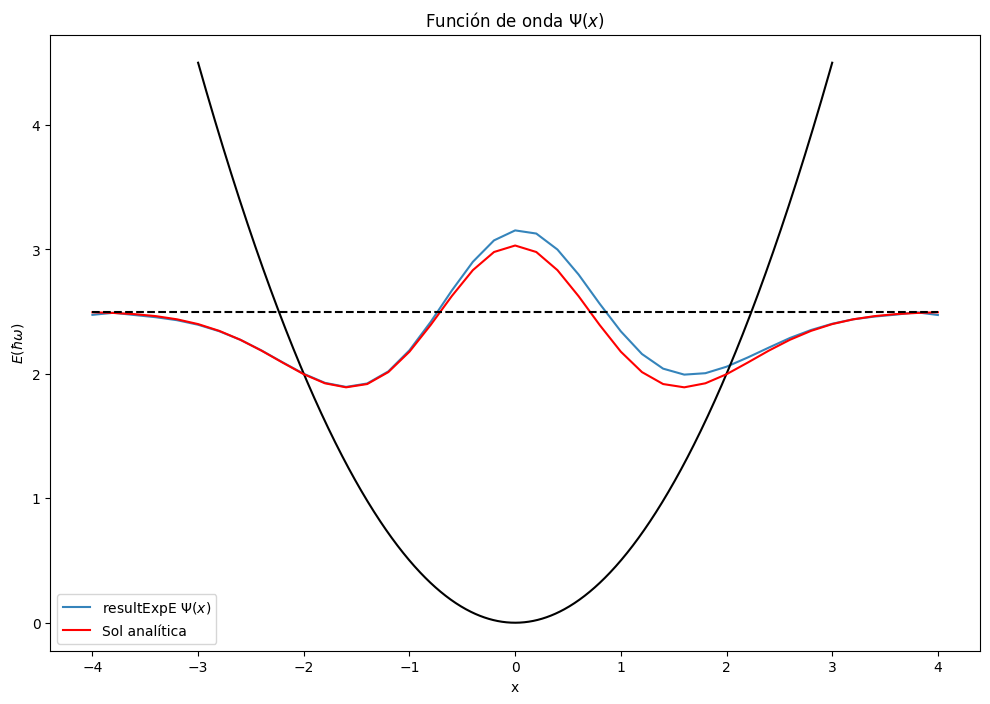

In [30]:
plt.figure(figsize=(12, 8))
for element in objects.keys():
    plt.plot(
        np.linspace(-4, 4, n_variables),
        2.5 + objects[element].sel_inds_hist[-1, 0, :-1],
        "-",
        label=f'{element.split("da_")[1]} $\Psi(x)$',
        alpha=0.9,
    )

plt.plot(np.linspace(-3, 3, 1000), 0.5 * np.linspace(-3, 3, 1000) ** 2, "k-")
plt.plot(np.linspace(-4, 4, n_variables), 2.5 + Psi2, "r-", label="Sol analítica")
plt.plot(np.linspace(-4, 4, 2), np.linspace(2.5, 2.5, 2), "k--")
plt.gca().set_title("Función de onda $\Psi(x)$")
plt.xlabel("x")
plt.gca().set_ylabel(r"$E(\hbar \omega)$")
plt.legend()

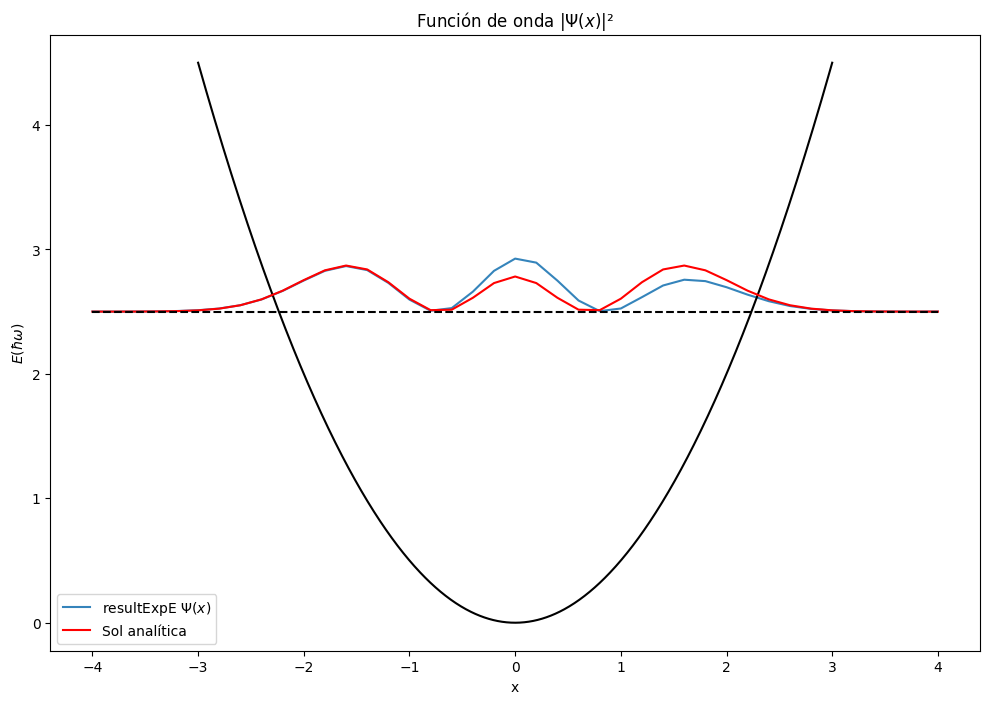

In [31]:
plt.figure(figsize=(12, 8))
for element in objects.keys():
    plt.plot(
        np.linspace(-4, 4, n_variables),
        2.5 + objects[element].sel_inds_hist[-1, 0, :-1] ** 2,
        "-",
        label=f'{element.split("da_")[1]} $\Psi(x)$',
        alpha=0.9,
    )

plt.plot(np.linspace(-3, 3, 1000), 0.5 * np.linspace(-3, 3, 1000) ** 2, "k-")
plt.plot(np.linspace(-4, 4, n_variables), 2.5 + Psi2**2, "r-", label="Sol analítica")
plt.plot(np.linspace(-4, 4, 2), np.linspace(2.5, 2.5, 2), "k--")
plt.gca().set_title("Función de onda $|\Psi(x)|²$")
plt.xlabel("x")
plt.gca().set_ylabel(r"$E(\hbar \omega)$")
plt.legend()

## Estado excitado n=3

In [32]:
def oneDHOExpE3(y: Union[np.array, list]) -> float:
    "Estamos discretizando el espacio entre los puntos x=-4 a x=4 con el número de puntos que se pasen como input al EDA"
    # Energy_lower bound
    E = (
        results_dict["eda_resultExpE1"].sel_inds_hist[-1, 0, -1] ** 0.5
        + results_dict["eda_resultExpE"].sel_inds_hist[-1, 0, -1] ** 0.5
        + results_dict["eda_resultExpE2"].sel_inds_hist[-1, 0, -1] ** 0.5
    )  # Exp E n=2
    # grid size x=[-4, 4]
    n = len(y)
    x = np.linspace(-4, 4, n)
    dx = 8 / (n - 1)
    # integral sums
    ExpE = 0
    j = 0
    orto = 0
    orto1 = 0
    orto2 = 0
    if (y[0] < -0.1 or y[0] > 0.1) or (y[n - 1] < -0.1 or y[n - 1] > 0.1):
        F = np.infty
        return F
    else:
        for i in range(n):
            if i == 0:
                ExpE = ExpE + y[i] * dx * (
                    -0.5 * (y[i] + y[i + 2] - 2 * y[i + 1]) / dx**2
                    + 0.5 * x[i] ** 2 * y[i]
                )
                j = j + y[i] ** 2 * dx
                orto = (
                    orto
                    + y[i]
                    * results_dict["eda_resultExpE"].sel_inds_hist[-1, 0, :-1][i]
                    * dx
                )
                orto1 = (
                    orto1
                    + y[i]
                    * results_dict["eda_resultExpE1"].sel_inds_hist[-1, 0, :-1][i]
                    * dx
                )
                orto2 = (
                    orto2
                    + y[i]
                    * results_dict["eda_resultExpE2"].sel_inds_hist[-1, 0, :-1][i]
                    * dx
                )

            elif i == n - 1:
                ExpE = ExpE + y[i] * dx * (
                    -0.5 * (y[i] + y[i - 2] - 2 * y[i - 1]) / dx**2
                    + 0.5 * x[i] ** 2 * y[i]
                )
                j = j + y[i] ** 2 * dx
                orto = (
                    orto
                    + y[i]
                    * results_dict["eda_resultExpE"].sel_inds_hist[-1, 0, :-1][i]
                    * dx
                )
                orto1 = (
                    orto1
                    + y[i]
                    * results_dict["eda_resultExpE1"].sel_inds_hist[-1, 0, :-1][i]
                    * dx
                )
                orto2 = (
                    orto2
                    + y[i]
                    * results_dict["eda_resultExpE2"].sel_inds_hist[-1, 0, :-1][i]
                    * dx
                )

            else:
                ExpE = ExpE + y[i] * dx * (
                    -0.5 * (y[i - 1] + y[i + 1] - 2 * y[i]) / dx**2
                    + 0.5 * x[i] ** 2 * y[i]
                )
                j = j + y[i] ** 2 * dx
                orto = (
                    orto
                    + y[i]
                    * results_dict["eda_resultExpE"].sel_inds_hist[-1, 0, :-1][i]
                    * dx
                )
                orto1 = (
                    orto1
                    + y[i]
                    * results_dict["eda_resultExpE1"].sel_inds_hist[-1, 0, :-1][i]
                    * dx
                )
                orto2 = (
                    orto2
                    + y[i]
                    * results_dict["eda_resultExpE2"].sel_inds_hist[-1, 0, :-1][i]
                    * dx
                )

    Z = (ExpE / j - E) ** 2 + 10 * orto**2 + 10 * orto1**2 + 10 * orto2**2
    # F = -1*np.exp(-cons*Z) #con signo menos global para minimizar
    return Z

In [33]:
if execute_edas:
    qumda = EGNA(
        size_gen=1500,
        max_iter=80,
        dead_iter=80,
        n_variables=n_variables,
        lower_bound=-1,
        upper_bound=1,
        alpha=0.6,
        parallelize=True,
        white_list=whites,
    )
    results_dict["eda_resultExpE3"] = qumda.minimize(oneDHOExpE3, True)

IT:  0 	Best cost:  999999999999


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  1 	Best cost:  240.16006792738384


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  2 	Best cost:  240.16006792738384


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  3 	Best cost:  240.16006792738384


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  4 	Best cost:  240.16006792738384


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  5 	Best cost:  240.16006792738384


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  6 	Best cost:  240.16006792738384


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  7 	Best cost:  240.16006792738384


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  8 	Best cost:  240.16006792738384


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  9 	Best cost:  240.16006792738384


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  10 	Best cost:  196.03335009902784


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  11 	Best cost:  196.03335009902784


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  12 	Best cost:  196.03335009902784


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  13 	Best cost:  98.28121998616585


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  14 	Best cost:  71.93829415616767
IT:  15 	Best cost:  41.91779609625469


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  16 	Best cost:  41.91779609625469


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  17 	Best cost:  38.216359166989754


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  18 	Best cost:  31.17707814593633


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  19 	Best cost:  22.268489327800506


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  20 	Best cost:  18.593219005039803


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  21 	Best cost:  17.121925360309074


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  22 	Best cost:  12.175112997981074


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  23 	Best cost:  8.265593657781636


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  24 	Best cost:  6.5332756232808045


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  25 	Best cost:  5.612343344320284


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  26 	Best cost:  3.9792243672635244


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  27 	Best cost:  2.6096877094218343


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  28 	Best cost:  2.6096877094218343


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  29 	Best cost:  2.083490270697022


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  30 	Best cost:  1.992260081533664


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  31 	Best cost:  1.992260081533664


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  32 	Best cost:  1.8453629630381836


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  33 	Best cost:  1.8023414793633166


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  34 	Best cost:  1.7233565986651123


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  35 	Best cost:  1.6967759659320525


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  36 	Best cost:  1.5751718312497633


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  37 	Best cost:  1.5143488802361407


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  38 	Best cost:  1.5143488802361407


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  39 	Best cost:  1.4705682213346


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  40 	Best cost:  1.4344435584428397


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  41 	Best cost:  1.396794617382411


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  42 	Best cost:  1.3471725394896248


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  43 	Best cost:  1.34594460416696


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  44 	Best cost:  1.3287011829793682


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  45 	Best cost:  1.2931790398626237


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  46 	Best cost:  1.2756385115359308


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  47 	Best cost:  1.271678521297882


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  48 	Best cost:  1.2488130242763482


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  49 	Best cost:  1.2488130242763482


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  50 	Best cost:  1.22970369199147


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  51 	Best cost:  1.22970369199147


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  52 	Best cost:  1.223278827782678


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  53 	Best cost:  1.2119787429413373


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  54 	Best cost:  1.20819667137985


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  55 	Best cost:  1.2028204272591032


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  56 	Best cost:  1.1974466876678778


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  57 	Best cost:  1.1943938219489687


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  58 	Best cost:  1.1878887522372643


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  59 	Best cost:  1.1852496483250496


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  60 	Best cost:  1.182683372688244


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  61 	Best cost:  1.18159568363937


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  62 	Best cost:  1.177820891563231


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  63 	Best cost:  1.17525231010973


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  64 	Best cost:  1.171891205859878


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  65 	Best cost:  1.1691398180237107


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  66 	Best cost:  1.1662704308977472


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  67 	Best cost:  1.1662704308977472


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  68 	Best cost:  1.1658865322133642


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  69 	Best cost:  1.164321376174444


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  70 	Best cost:  1.1647055831748916


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  71 	Best cost:  1.163208078517537


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  72 	Best cost:  1.1620379581161346


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  73 	Best cost:  1.1609397182470933


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  74 	Best cost:  1.161032483638755


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  75 	Best cost:  1.16007160379081


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  76 	Best cost:  1.1592516995212994


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  77 	Best cost:  1.158948197785086


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  78 	Best cost:  1.158194787414009


/home/dani/.local/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


IT:  79 	Best cost:  1.1572656333911049
	NFEVALS = 120000 F = 1.1572656333911049
	X = [[ 0.08342576  0.09426341  0.29114721  0.50588211  0.81611982  1.2222615
   1.69608437  2.18559296  2.64017912  2.99555904  3.06220941  2.71285485
   1.99803944  0.89313652 -0.37880757 -1.55305613 -2.34965026 -2.65036201
  -2.3304467  -1.44187023 -0.10795203  1.36088949  2.36646004  2.66146469
   2.31579669  1.52288193  0.43614092 -0.93552905 -1.91287103 -2.73173259
  -3.06958998 -2.75905262 -2.28981263 -1.94042528 -1.48716018 -1.04774854
  -0.71136121 -0.44066815 -0.26298266 -0.09693037 -0.08316269]]


In [34]:
objects = {"eda_resultExpE": results_dict["eda_resultExpE3"]}


# Cálculo de las constantes para normalización mejor solución
for element in objects.keys():
    integral = 0
    for i in range(len(objects[element].sel_inds_hist[-1, 0, :-1])):
        integral = integral + (objects[element].sel_inds_hist[-1, 0, :-1][i] ** 2) * (
            8 / (n_variables - 1)
        )

    B = (1 / integral) ** 0.5
    objects[element].sel_inds_hist[-1, 0, :-1] = (
        B * objects[element].sel_inds_hist[-1, 0, :-1]
    )

In [35]:
print(
    "La energía esperada de la solución encontrada es:",
    results_dict["eda_resultExpE1"].sel_inds_hist[-1, 0, -1] ** 0.5
    + results_dict["eda_resultExpE"].sel_inds_hist[-1, 0, -1] ** 0.5
    + results_dict["eda_resultExpE2"].sel_inds_hist[-1, 0, -1] ** 0.5
    + results_dict["eda_resultExpE3"].sel_inds_hist[-1, 0, -1] ** 0.5,
    "\nEl valor teórico es 3.5",
)

La energía esperada de la solución encontrada es: 3.481784932133169 
El valor teórico es 3.5


In [36]:
Psi3 = np.exp(-np.linspace(-4, 4, n_variables) ** 2 / 2) * (
    8 * np.linspace(-4, 4, n_variables) ** 3 - 12 * np.linspace(-4, 4, n_variables)
)
integral = 0
for i in range(len(Psi3)):
    integral = integral + (Psi3[i] ** 2) * (8 / (len(Psi3) - 1))

B = (1 / integral) ** 0.5
Psi3 = B * Psi3

if results_dict["eda_resultExpE3"].sel_inds_hist[-1, 0, :-1][10] > 0:
    Psi3 = -Psi3

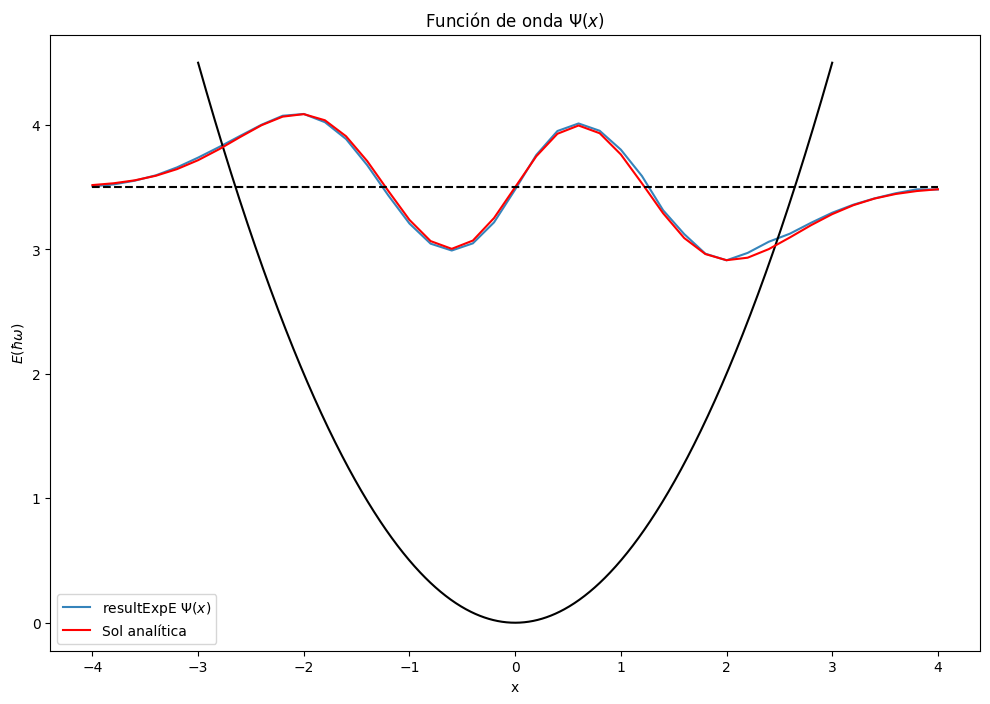

In [37]:
plt.figure(figsize=(12, 8))
for element in objects.keys():
    plt.plot(
        np.linspace(-4, 4, n_variables),
        3.5 + objects[element].sel_inds_hist[-1, 0, :-1],
        "-",
        label=f'{element.split("da_")[1]} $\Psi(x)$',
        alpha=0.9,
    )

plt.plot(np.linspace(-3, 3, 1000), 0.5 * np.linspace(-3, 3, 1000) ** 2, "k-")
plt.plot(np.linspace(-4, 4, n_variables), 3.5 + Psi3, "r-", label="Sol analítica")
plt.plot(np.linspace(-4, 4, 2), np.linspace(3.5, 3.5, 2), "k--")
plt.gca().set_title("Función de onda $\Psi(x)$")
plt.xlabel("x")
plt.gca().set_ylabel(r"$E(\hbar \omega)$")
plt.legend()

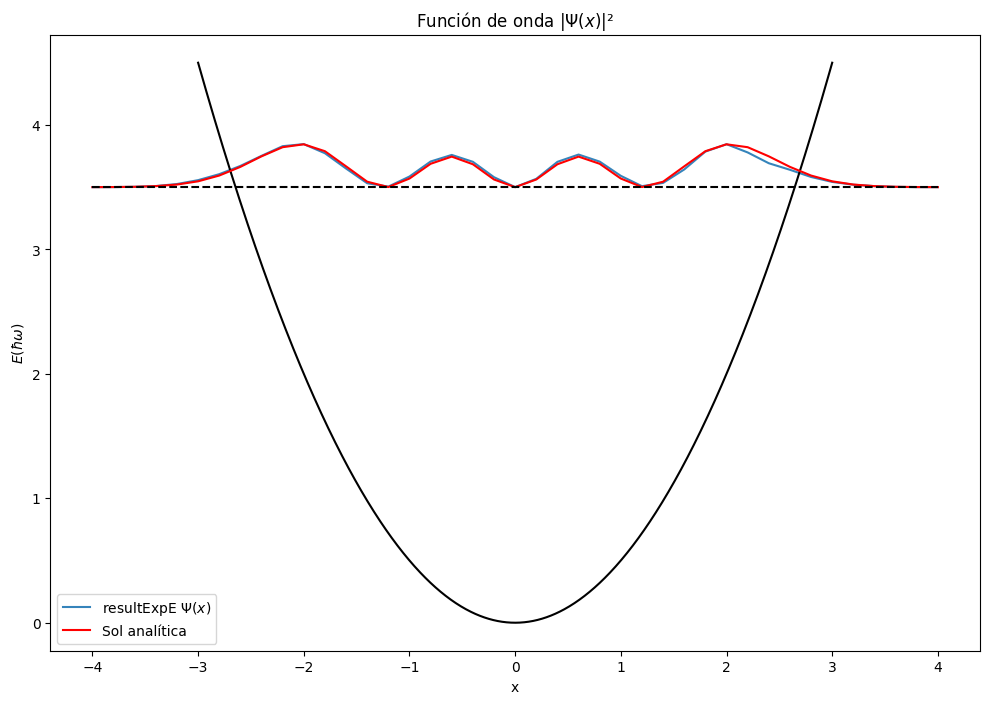

In [38]:
plt.figure(figsize=(12, 8))
for element in objects.keys():
    plt.plot(
        np.linspace(-4, 4, n_variables),
        3.5 + objects[element].sel_inds_hist[-1, 0, :-1] ** 2,
        "-",
        label=f'{element.split("da_")[1]} $\Psi(x)$',
        alpha=0.9,
    )

plt.plot(np.linspace(-3, 3, 1000), 0.5 * np.linspace(-3, 3, 1000) ** 2, "k-")
plt.plot(np.linspace(-4, 4, n_variables), 3.5 + Psi3**2, "r-", label="Sol analítica")
plt.plot(np.linspace(-4, 4, 2), np.linspace(3.5, 3.5, 2), "k--")
plt.gca().set_title("Función de onda $|\Psi(x)|²$")
plt.xlabel("x")
plt.gca().set_ylabel(r"$E(\hbar \omega)$")
plt.legend()

## Guardar soluciones
Si se han ejectuado los EDAs se sobreescriben las soluciones anteriores almancenadas.

In [39]:
if execute_edas:
    for key in results_dict:
        with open(f"{ruta}/{key}.pkl", "wb") as file:
            pickle.dump(results_dict[key], file)

# Visualización soluciones
Vamos a comprobar cómo han evolucionado las soluciones del EDA en el caso n=3. Todas las soluciones existidas son previamente normalizadas, y se escoge el signo de la función analítica automáticamente para que coincida con el que alcanza la solución del EDA final.

In [40]:
# Psi3 = np.exp(-np.linspace(-4,4,n_variables)**2/2)*(8*np.linspace(-4,4,n_variables)**3-12*np.linspace(-4,4,n_variables))
# integral =0
# for i in range(len(Psi3)):
#     integral = integral + (Psi3[i]**2)*(8/(len(Psi3)-1))

# B = (1/integral)**0.5
# Psi3 = B * Psi3


# if results_dict['eda_resultExpE3'].sel_inds_hist[-1,0,:-1][10]>0:
#     Psi3 = -Psi3

In [41]:
# ###Normalizamos todas las soluciones/individuos seleccionados de todas las generaciones para visualizar solo para el caso n=3
# #Empty array to store normalized values
# shape = (len(results_dict['eda_resultExpE3'].sel_inds_hist), len(results_dict['eda_resultExpE3'].sel_inds_hist[0,:,0]), len(results_dict['eda_resultExpE3'].sel_inds_hist[-1,0,:-1])+1)
# Neda_resultExpE3selinds = np.empty(shape)

# for gen in range(len(results_dict['eda_resultExpE3'].sel_inds_hist)):
#     for ind in range(len(results_dict['eda_resultExpE3'].sel_inds_hist[0,:,0])):
#         integral =0
#         for var in range(len(results_dict['eda_resultExpE3'].sel_inds_hist[-1,0,:-1])):
#             integral = integral + (results_dict['eda_resultExpE3'].sel_inds_hist[gen,ind,:-1][var]**2)*(8/(n_variables-1))

#         B = (1/integral)**0.5
#         Neda_resultExpE3selinds[gen,ind,:-1] = B * results_dict['eda_resultExpE3'].sel_inds_hist[gen,ind,:-1]
#         Neda_resultExpE3selinds[gen, ind, -1] = results_dict['eda_resultExpE3'].sel_inds_hist[gen, ind,-1]

In [42]:
## Plot secuencial con KDE para cada variable
# from IPython.display import clear_output
# import time


# for i in range(len(Neda_resultExpE3selinds)):
#     plt.figure(figsize=(20, 8))
#     plt.clf()  # Clear previous plot

#     edadf = pd.DataFrame(Neda_resultExpE3selinds[i,:,:-1], columns=np.arange(0, n_variables, 1).tolist())
#     edadf['ev'] = Neda_resultExpE3selinds[i,:,-1]
#     #Find the row index with the smallest 'ev' value
#     min_ev_row_index = edadf['ev'].idxmin()
#     # Extract the data of the row with the smallest 'ev' value
#     min_ev_row_data = edadf.iloc[min_ev_row_index, :-1].tolist()

#     data = []
#     for col in edadf:
#         data.append(edadf[col])

#     plt.violinplot(data[:-1], showmeans=True)
#     # Adding a line representing the row with the smallest 'ev' value
#     plt.plot(np.arange(1, len(min_ev_row_data) + 1), min_ev_row_data, label='Best ind', color='red')
#     # Adding a line representing analytic solution
#     plt.plot(np.arange(1,n_variables+1,1), Psi3, 'k-')
#     # Adding legend
#     plt.legend()
#     plt.xlabel("Variables")
#     plt.xticks(np.arange(0,n_variables,1))
#     plt.ylabel("Valores")
#     #y_ticks = np.arange(-1, 1.2, 0.2)
#     #plt.yticks(y_ticks)
#     #plt.grid()
#     plt.title(f"Gen {i + 1}")  # Adjust title according to i
#     plt.legend().remove()

#     plt.suptitle('Evolución Individuos', fontsize=20)
#     plt.subplots_adjust(top=0.92)
#     plt.show()

#     # Add a delay
#     #time.sleep(0.1)

#     # Clear the output to display the next plot
#     clear_output(wait=True);

In [43]:
## Plot con slider para un resultado concreto
# from IPython.display import clear_output
# import time
# import ipywidgets as widgets
# from ipywidgets import interact

# # Function to update the plot based on the selected generation
# def update_plot(i):
#     plt.figure(figsize=(20, 8))
#     plt.clf()  # Clear previous plot

#     edadf = pd.DataFrame(Neda_resultExpE3selinds[i, :, :-1], columns=np.arange(0, n_variables, 1).tolist())
#     edadf['ev'] = Neda_resultExpE3selinds[i, :, -1]
#     min_ev_row_index = edadf['ev'].idxmin()
#     min_ev_row_data = edadf.iloc[min_ev_row_index, :-1].tolist()

#     data = []
#     for col in edadf:
#         data.append(edadf[col])

#     plt.violinplot(data[:-1], showmeans=True)
#     plt.plot(np.arange(1, len(min_ev_row_data) + 1), min_ev_row_data, label='Best ind', color='red')
#     plt.plot(np.arange(1, n_variables + 1, 1), Psi3, 'k-')
#     plt.legend()
#     plt.xlabel("Variables")
#     plt.xticks(np.arange(0, n_variables, 1))
#     plt.ylabel("Valores")
#     plt.title(f"Gen {i + 1}")
#     plt.legend().remove()

#     plt.suptitle('Evolución Individuos', fontsize=20)
#     plt.subplots_adjust(top=0.92)
#     plt.show()

# # Create a slider widget
# generation_slider = widgets.IntSlider(value=0, min=0, max=len(Neda_resultExpE3selinds)-1, step=1, description='Generation', layout=widgets.Layout(width='100%'), )


# # Use interact to connect the slider with the update_plot function
# interact(update_plot, i=generation_slider);

# # Uncomment the following line if you want to display the initial plot without interaction
# # update_plot(0)

# Visualización y Normalización de todas las soluciones para todos los niveles energéticos
Creamos un diccionario que contenga las soluciones normalizadas de  cada nivel energético calculado

In [44]:
# Normalización de todas las soluciones para todos los niveles energéticos calculados
Nresults_dict = {}
for key in results_dict.keys():
    shape = (
        len(results_dict[key].sel_inds_hist),
        len(results_dict[key].sel_inds_hist[0, :, 0]),
        len(results_dict[key].sel_inds_hist[-1, 0, :-1]) + 1,
    )
    Neda_result = np.empty(shape)
    for gen in range(len(results_dict[key].sel_inds_hist)):
        for ind in range(len(results_dict[key].sel_inds_hist[0, :, 0])):
            integral = 0
            for var in range(len(results_dict[key].sel_inds_hist[-1, 0, :-1])):
                integral = integral + (
                    results_dict[key].sel_inds_hist[gen, ind, :-1][var] ** 2
                ) * (8 / (n_variables - 1))

            B = (1 / integral) ** 0.5
            Neda_result[gen, ind, :-1] = (
                B * results_dict[key].sel_inds_hist[gen, ind, :-1]
            )
            Neda_result[gen, ind, -1] = results_dict[key].sel_inds_hist[gen, ind, -1]
    Nresults_dict[f"N{key}"] = Neda_result

In [45]:
# Given dictionary Nresults_dict
analytical = [
    Psi0,
    Psi1,
    Psi2,
    Psi3,
]  ## Las funciones corrigen el signo en la propia definición de la función.
# Create a new dictionary with the same keys from Nresults_dict and values in analytical list
analytic_sols_dict = {key: value for key, value in zip(Nresults_dict, analytical)}

In [46]:
from IPython.display import clear_output
import time
import ipywidgets as widgets
from ipywidgets import interact


# Function to update the plot based on the selected generation
def update_plot(i, n):
    max_generation = len(Nresults_dict[n]) - 1
    plt.figure(figsize=(20, 8))
    plt.clf()  # Clear previous plot

    edadf = pd.DataFrame(
        Nresults_dict[n][i, :, :-1], columns=np.arange(0, n_variables, 1).tolist()
    )
    edadf["ev"] = Nresults_dict[n][i, :, -1]
    min_ev_row_index = edadf["ev"].idxmin()
    min_ev_row_data = edadf.iloc[min_ev_row_index, :-1].tolist()

    generation_slider.max = max_generation
    # generation_slider.value = min(i, max_generation)

    data = []
    for col in edadf:
        data.append(edadf[col])

    plt.violinplot(data[:-1], showmeans=True)
    plt.plot(
        np.arange(1, len(min_ev_row_data) + 1),
        min_ev_row_data,
        label="Best individual",
        color="red",
    )
    plt.plot(
        np.arange(1, n_variables + 1, 1),
        analytic_sols_dict[n],
        "k-",
        label="Analytic solution",
    )
    plt.legend()
    plt.xlabel("Variables")
    plt.xticks(np.arange(1, n_variables + 1, 1))
    if n == E_level_keys[0]:
        plt.ylim((-0.2, 1.2))
    else:
        plt.ylim((-1.6, 1.6))
    plt.ylabel("Valores")
    plt.title(f"Gen {i}")
    plt.legend()

    plt.suptitle("Evolución Individuos", fontsize=20)
    plt.subplots_adjust(top=0.92)
    plt.show()


# Create a slider widget
E_level_keys = list(Nresults_dict.keys())
E_level_slider = widgets.Dropdown(
    options=E_level_keys,
    value=E_level_keys[0],
    description="E level",
    layout=widgets.Layout(width="100%"),
    orientation="vertical",
)
generation_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=0,  # len(Nresults_dict[E_level_slider])-1,
    step=1,
    description="Generation",
    layout=widgets.Layout(width="100%"),
)


# Use interact to connect the slider with the update_plot function
interact(update_plot, i=generation_slider, n=E_level_slider)

interactive(children=(IntSlider(value=0, description='Generation', layout=Layout(width='100%'), max=118), Drop…